# 0. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.express as px
import seaborn as sns
#sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 1. Import Data
Let's look at 5 random controls and 5 random PanIN samples. This is only to start to get an idea of what the spectrometry data looks like. 

First things first. The data files have very long names. I couldn't find out if thesse names were associated with some kind of information. I will start off by renaming all files in each folder to something more digestible. I may have to revisit this step if the file name do in fact, turn out to be important. Only one way to find out. 

In [2]:
import os

# Switch to folder with 'control' files
os.chdir(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control')

# Check if I'm in the right directory
#print(os.getcwd())

# Create arrays to store new file names
control_samples = []
panIN_samples = []

# Rename files in the Control folder
for file in os.listdir():
    #print(file)     # Get file names
    #print(os.path.splitext(file))     # Separate file name from extension
    file_name, file_ext = os.path.splitext(file)     # Store the file name and extensions
    new_name = '{}{}'.format(file_name.split('_')[0], file_ext)     # Grab the first identifying number for each file
    #print(new_name)     # Confirm that the name tghwe have the name we want
    os.rename(file,new_name)     # Rename files
    control_samples.append(file)     # Append new file names to array
    
# Rename files in the PanIN folder
os.chdir(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN')
for file in os.listdir():
    file_name, file_ext = os.path.splitext(file)     # Store the file name and extensions
    new_name = '{}{}'.format(file_name.split('_')[0], file_ext)     # Grab the first identifying number for each file
    #print(new_name)     # Confirm that the name we have the name we want
    os.rename(file,new_name)     # Rename files
    panIN_samples.append(file)     # Append new file names to array
    
print(len(control_samples))
print(len(panIN_samples))

101
80


# 2. Exploratory Data Analysis

## 2.1 Create visualizations on a few samples

So we have 101 control samples and 80 PanIN samples. Not the biggest sample size but we work with what we have. 

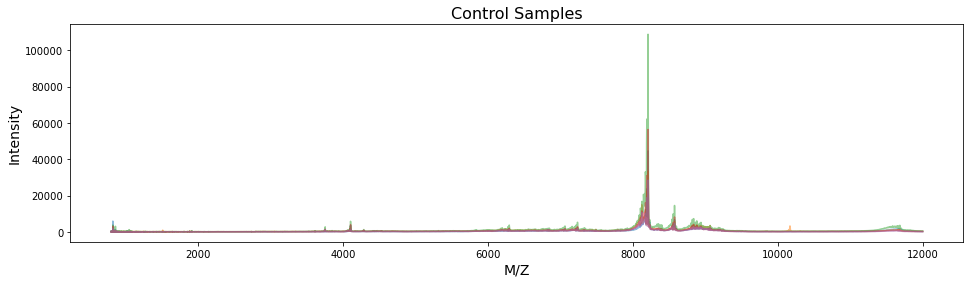

In [3]:
# Plot 5 random control samples
plt.figure(figsize=(16,4))
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('Control Samples', fontsize=16)

# Read in 5 random Control samples
for i in range(0,5):
    n = np.random.randint(low=0, high=len(control_samples))
    cs = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control\{}'.format(control_samples[n]))
    plt.plot(cs['M/Z'], cs['Intensity'], alpha=0.5)

On a quick (and crude) visual inspection, the spectrometry files seem to show consistent peaks for the 5 random control samples. Let's try the same for the PanIN samples.

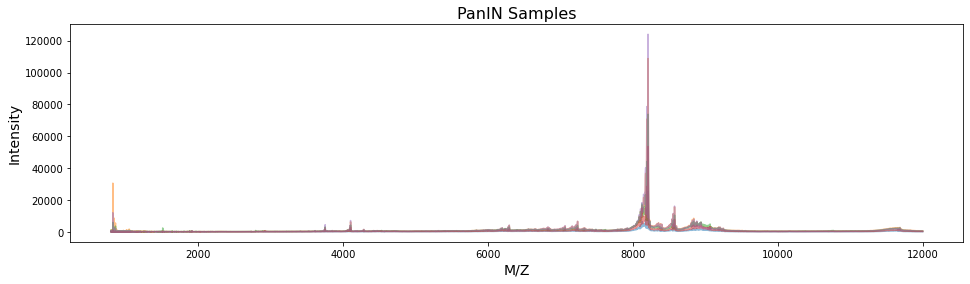

In [4]:
# Plot 5 random PanIN samples
plt.figure(figsize=(16,4))
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('PanIN Samples', fontsize=16)

# Read in 5 random PanIN samples
for i in range(0,5):
    n = np.random.randint(low=0, high=len(panIN_samples))
    ps = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN\{}'.format(panIN_samples[n]))
    plt.plot(ps['M/Z'], ps['Intensity'], alpha=0.5)

Some PanIN samples show random peaks, but overall the peaks still seem fairly consistent. Now let's compare the controls and PanIN samples.

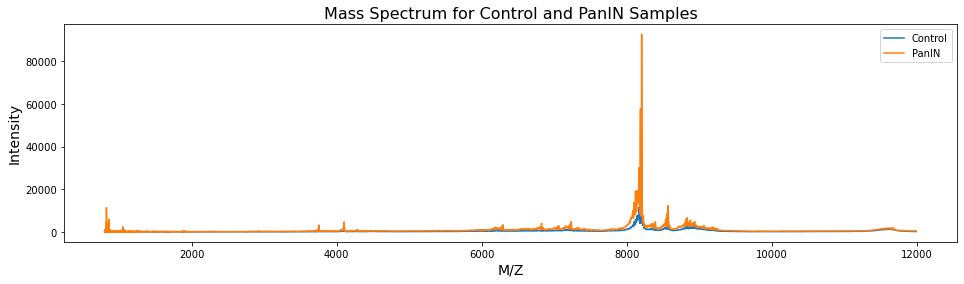

In [5]:
n = np.random.randint(low=0, high=len(control_samples))
cs = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control\{}'.format(control_samples[n]))
m = np.random.randint(low=0, high=len(panIN_samples))
ps = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN\{}'.format(panIN_samples[m]))
                                                                                                                      
plt.figure(figsize=[16,4])
plt.plot(cs['M/Z'], cs['Intensity'], label='Control')
plt.plot(ps['M/Z'], ps['Intensity'], label='PanIN')
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('Mass Spectrum for Control and PanIN Samples', fontsize=16)
plt.legend()
plt.savefig(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Figures\Mass Spectrum.png')

If we were to just try to visually compare the spectra for a control and a PanIN sample, we could identify some peaks fairly well. But it would be quite difficult to identify all the key biomarkers. This is why we are trying to train a model to do this for us! 

In [6]:
cs.head()

,M/Z,Intensity
0,800.00000,107.0
1,800.32000,151.0
2,800.64014,43.0
3,800.96040,130.0
4,801.28076,312.0


## 2.2 Noise Reduction and Scaling Data
The intensity values have a veery large range. Scaling the data may allow for better visualization. The idea here is to reduce noise and scale the data without losing any information. Using a standard scaler object did not seem to give good results, so I have attempted to manually scale the data. 

In [7]:
# Baseline subtraction: Subtract the median of the bottom 20% of intensity values from all the values. 
# This should remove some of the noise. Might have to play around a little bit to make sure no information is lost. 
bottom_median = np.median(np.sort(cs['Intensity'])[:len(cs['Intensity'])//5])
cs['Intensity'] = cs['Intensity'].apply(lambda x: x-bottom_median if (x-bottom_median)>=0 else 0)
#cs = cs[cs['M/Z'] < 11000]

cs.head()

,M/Z,Intensity
0,800.00000,44.0
1,800.32000,88.0
2,800.64014,0.0
3,800.96040,67.0
4,801.28076,249.0


In [8]:
# Rescaling: Divide all the values by the median of the top 5% intensity values
top_median = np.median(np.sort(cs['Intensity'])[::-1][:(len(cs['Intensity'])//20)])
cs['Intensity'] = cs['Intensity'].apply(lambda x: x/top_median)

# Take the square root to 'compress' the intensity values a little. 
# The actual intensity values are not important. We just need to be able to identify and visualize the peaks.  
cs['Intensity'] = np.sqrt(cs['Intensity'])
cs.head()


,M/Z,Intensity
0,800.00000,0.175565
1,800.32000,0.248287
2,800.64014,0.000000
3,800.96040,0.216645
4,801.28076,0.417649


In [9]:
cs.describe()

,M/Z,Intensity
count,6771.000000,6771.000000
mean,4134.434794,0.288822
std,3059.113720,0.298417
min,800.000000,0.000000
25%,1574.160100,0.095430
50%,3097.470200,0.213387
75%,6094.888700,0.377103
max,11992.908000,5.281299


#### Create more visualizations with the scaled data

Let's now visualize this information as a colorbar, along with the spectrogram. The colorbar is simly a different way to visualize the spectrogram information. The more yellow the vertical line, the higher the intensity at that M/Z value. 

Note that most of the colorbar here will be blue, meaning the intensities for most of the M/Z values are near zero. The colorbar would be alot more useful if the intensity values were normalized from the device at the time of data collection. 


Note: This is  a colorbar for a single sample. Once all the samples are combined into a dataset, the rows will  refer to the corresponding sample number.

Text(0.5, 0, 'M/Z')

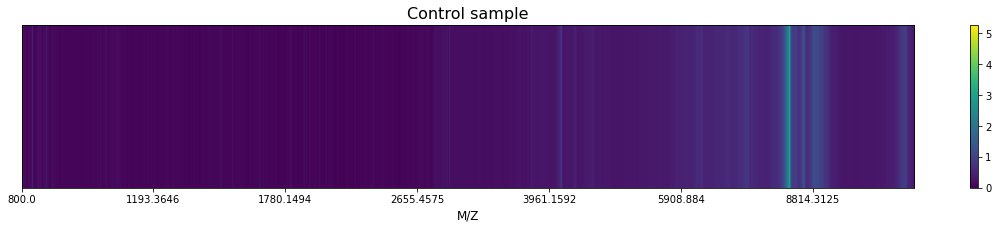

In [10]:
# Plot the spectrogram as a colorbar
cs.set_index('M/Z')
plt.figure(figsize =(20,3))
plt.title('Control sample', fontsize = 16)
plt.imshow(cs['Intensity'][np.newaxis,:], aspect='auto', cmap='viridis')#, extent=[0,max(cs['M/Z']),2,0])
plt.yticks([])
plt.xticks(np.arange(0,7000,1000), cs['M/Z'][0:7000:1000])
plt.colorbar()
plt.xlabel('M/Z', fontsize = 12)

In order to identify the M/Z value for the associated peak, let's plot the spectrogram in an interactive plot. Note that intensity here actually refers to the scaled intensity. 

In [11]:
#px.line(cs, x=cs['M/Z'],y=cs['Intensity'], width = 1000, height = 300, title='Mass Spectrum')

## 2.3 Scaling and Visualization on all Samples

### 2.3.1 Combine all the samples into a single DataFrame
We want the rows to represent samples, and the columns to represent different M/Z values. 

The following steps are employed to achieve this:
* Step 1: Define a function that: 
    * Reads in a csv file from a specified path,
    * Applies the necessary scaling transformations,
    * Converts the rows to columns as required, and
    * Returns transformed DataFrame.
* Step 2: Define a function that combines all the transformed DataFrames (i.e. appends to a previously defined DataFrame 
* Step 3: Call the functions!

In [12]:
cs = cs.set_index('M/Z')

In [13]:
cs.transpose()

M/Z,800.00000,800.32000,800.64014,800.96040,801.28076,801.60126,801.92190,802.24260,802.56354,802.88460,...,11949.82000,11954.60100,11959.38300,11964.16700,11968.95300,11973.74000,11978.52900,11983.32000,11988.11300,11992.90800
Intensity,0.175565,0.248287,0.0,0.216645,0.417649,0.121289,0.132337,0.256611,0.149722,0.330578,...,0.38355,0.376173,0.368649,0.366744,0.359022,0.35113,0.359022,0.355098,0.363867,0.326313


#### Define the transformation and scaling function:

In [14]:
def transform_data(file_path):
    df = pd.read_csv(file_path)
    
    
    # Baseline substration. Substract the spectra with the median of bottom 20% intensity
    bottom_median = np.median(np.sort(df['Intensity'])[:len(df['Intensity'])//5])
    df['Intensity'] = df['Intensity'].apply(lambda x: x-bottom_median if (x-bottom_median)>=0 else 0)
    
    # Rescaling: Divide all the values by the highest intensity value
    # Update: This was throwing off results completely. Look into why this is the case.
    # Dividing by the median of the top values works better
    #df['Intensity'] = df['Intensity'] / np.max(df['Intensity'])

    # Rescale by dividing the intensity with the median of top 5% intensity
    top_median = np.median(np.sort(df['Intensity'])[::-1][:(len(df['Intensity'])//20)])
    df['Intensity'] = df['Intensity'].apply(lambda x: x/top_median)
            
    # Take the square root to 'compress' the intensity values a little. 
    # The actual intensity values are not important. We just need to be able to identify and visualize the peaks.  
    df['Intensity'] = np.sqrt(df['Intensity'])
    
    # Transpose the data as shown in the example above
    df = df.set_index('M/Z')
    df_transformed = df.transpose()

    
    return df_transformed

#### Define a function to read and combine all the samples:

In [15]:
def combine_data(folder_path):
    df = pd.DataFrame()
    for file in os.listdir(folder_path):
        transformed = transform_data(file)
        df = pd.concat((df,transformed), ignore_index=True)
        
    return df    

#### These are the folders the files are stored in:

In [16]:
# Control Samples are stored here
control_path = r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control'

# PanIN samples are stored here
panIN_path = r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN'

#### Call functions to make the combined dataset with all samples for each group

In [17]:
os.chdir(control_path)
df_control = combine_data(os.getcwd())

os.chdir(panIN_path)
df_panIN = combine_data(os.getcwd())

#### Define a function to combine the control and panIN samples, and add a binary column titled 'has disease' to identify the sample

In [18]:
def create_data_result(disease_group, control_group):
    disease_group['has disease'] = 1
    control_group['has disease'] = 0
    df = pd.concat((disease_group, control_group), ignore_index=True)
    return df

The data frame below now has both the control and disease datasets combined, along with an identifying column titled 'has disease'

In [19]:
df_full= create_data_result(df_panIN, df_control)

### 2.3.2 Create spectrographs for both groups

#### Define a function to create a combined colorbar for all the samples in each group

In [20]:
df_control.head()

M/Z,800.0,800.32,800.64014,800.9604,801.28076,801.60126,801.9219,802.2426,802.56354,802.8846,...,11954.601,11959.383,11964.167,11968.953,11973.74,11978.529,11983.32,11988.113,11992.908,has disease
0,0.192889,0.245721,0.000000,0.348439,0.352166,0.000000,0.261797,0.260548,0.102195,0.308178,...,0.390404,0.371996,0.378519,0.367139,0.359504,0.359504,0.341820,0.352629,0.365803,0
1,0.260186,0.270584,0.000000,0.394965,0.408699,0.000000,0.274633,0.312836,0.027126,0.292159,...,0.322677,0.338807,0.337719,0.312247,0.320962,0.332228,0.331118,0.313423,0.312836,0
2,0.165119,0.255259,0.048068,0.222363,0.768187,0.240340,0.174640,0.464050,0.276130,0.337847,...,0.326721,0.323166,0.323880,0.323880,0.326013,0.333025,0.305525,0.307034,0.275292,0
3,0.212211,0.281291,0.000000,0.290129,0.637955,0.203091,0.220002,0.431308,0.227525,0.331434,...,0.379948,0.361208,0.358870,0.344510,0.353553,0.351763,0.348155,0.337100,0.357696,0
4,0.209160,0.253305,0.000000,0.338339,0.352068,0.071442,0.210895,0.258293,0.109684,0.363781,...,0.338339,0.324029,0.347901,0.341022,0.322337,0.320067,0.320067,0.320636,0.316055,0


In [21]:
def combined_colorbar(dataset):
    plt.figure(figsize=(20,3))
    plt.imshow(dataset, aspect='auto', cmap='viridis')
    plt.xticks(np.arange(0, 7000, 1000), dataset.columns[0:7000:1000])
    plt.colorbar()

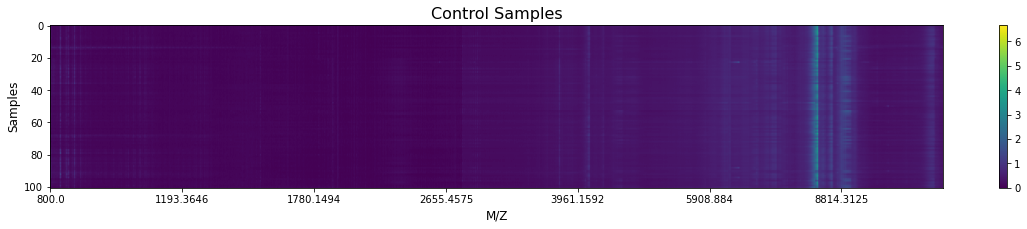

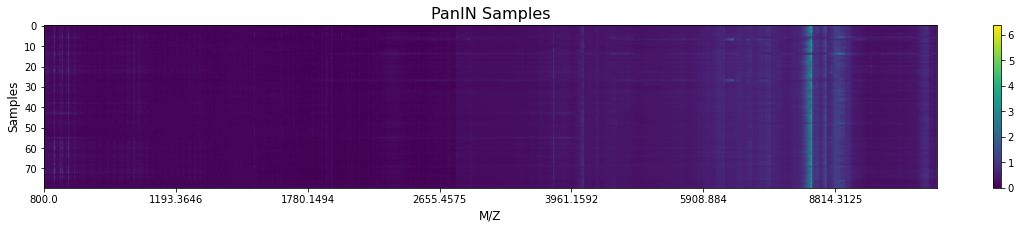

In [22]:
combined_colorbar(df_control)
plt.title('Control Samples', fontsize = 16)
plt.xlabel('M/Z', fontsize = 12)
plt.ylabel('Samples', fontsize = 12)
plt.savefig(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Figures\Spectrogram Control.png')

combined_colorbar(df_panIN)
plt.title('PanIN Samples', fontsize = 16)
plt.xlabel('M/Z', fontsize = 12)
plt.ylabel('Samples', fontsize = 12)
plt.savefig(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Figures\Spectrogram PanIN.png')

### 2.3.3 Principal Component  Analysis and visualization

The spectrographs give a good intuitive understanding of the intensity values for different M/Z values. But it is still difficult to visually inspect the two and gather any differences between the two groups. This is perfect use case for Principal Component Analysis: a small but highly-dimensional dataset. We can plot the first two principal components.

In [23]:
from sklearn.decomposition import PCA

X = df_full.drop('has disease', axis=1)
y = df_full['has disease']

pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)
#X.shape
#X_pca.shape

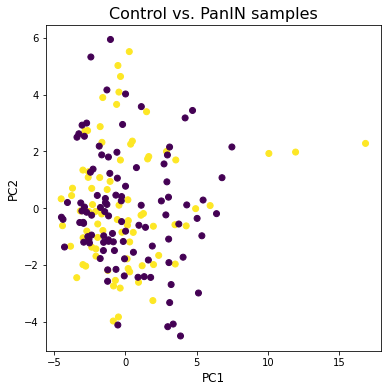

In [24]:
# Scatter plot of first two principal components
plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_full['has disease'])
plt.title('Control vs. PanIN samples', fontsize=16)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.savefig(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Figures\PCA.png')

Unfortunately, it doesn't look like 2 principal components can explain enough variance to distinguish between the two samples.
One question to answer is, how many components can explain a sufficient amount of variance?

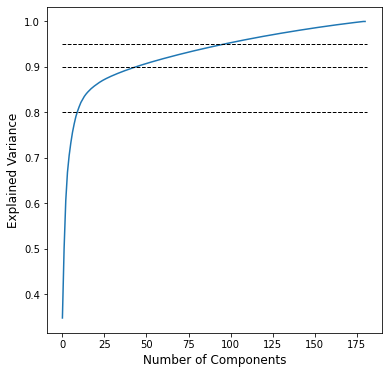

In [25]:
plt.figure(figsize=[6,6])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot([0, X_pca.shape[0]], [0.8, 0.8], color='k', linestyle='dashed', linewidth = 1)
plt.plot([0, X_pca.shape[0]], [0.9, 0.9], color='k', linestyle='dashed', linewidth = 1)
plt.plot([0, X_pca.shape[0]], [0.95, 0.95], color='k', linestyle='dashed', linewidth = 1)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Explained Variance', fontsize=12)
plt.savefig(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Figures\Variance explained.png')

- It takes around 10 components to explain 80% of the variance, but about 100 to explain 95% of the variance. 
- 2 components only explain about 50% of the variance. This makes visualization difficult as evidenced by the PC2 vs PC1 plot. 

#  3. Machine Learning


Before we get to start classifying samples, we need to create a baseline model, tune hyperparameters, and do some feature selection. 

I will follow the steps outlined below:
- Train baseline random forest classifier
- Identify the most important features that describe the variance upto a certain threshold (say 95%)
- Create a new dataset with just the identified important features
- Train a second classifer on this new dataset
- Potentially compare with different machine learning algorithms and pick the best result

## 3.1 Train Baseline Model

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

rf_base = RandomForestClassifier()
rf_base.fit(X_train,y_train)

pred_rf_baseline = rf_base.predict(X_test)

print(classification_report(y_test, pred_rf_baseline, labels=[1,0]))
print(confusion_matrix(y_test, pred_rf_baseline, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.50      0.33      0.40        24
           0       0.59      0.74      0.66        31

    accuracy                           0.56        55
   macro avg       0.54      0.54      0.53        55
weighted avg       0.55      0.56      0.54        55

[[ 8 16]
 [ 8 23]]


## 3.2 Identify Important features

Of the ~6700 M/Z values, about 900 are needed to explain 95% of the variance. This will improve computation  time

Text(0, 0.5, 'Explained Variance')

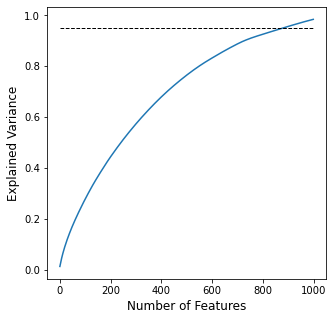

In [27]:
important_features = rf_base.feature_importances_

plt.figure(figsize=(5,5))
plt.plot(np.cumsum(np.sort(important_features)[::-1][:1000]))
plt.plot([0, 1000], [0.95, 0.95], color='k', linestyle='dashed', linewidth = 1)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Explained Variance', fontsize=12)

In [28]:
important_features = list(zip(rf_base.feature_importances_, X.columns))
important_features.sort(reverse=True)

n = 0
feature_names = [feat[1] for feat in important_features[:900]]  # List of top 900 most important features (M/Z values)

#### Create new dataset with only top features

We  have identified the important features. Now we need to go back to the dataframe and select these columns only.

In [29]:
X_new = X[feature_names]
X_new.head(5)

M/Z,1858.72110,9555.91900,11685.17200,1060.56320,1273.74780,11358.04500,11476.76100,11339.89000,4212.78800,10705.29000,...,977.86505,1328.90490,7535.37300,11978.52900,1972.84580,1529.78550,1639.37270,1791.57680,6564.23240,7969.30400
0,0.187462,0.499095,0.751226,0.301589,0.000000,0.877511,0.900761,0.830927,0.358002,0.746395,...,0.140137,0.0,0.755343,0.613374,0.763509,0.200774,0.231833,0.167054,0.678956,0.797282
1,0.139810,0.334590,0.706635,0.186149,0.136596,0.509789,0.705692,0.476922,0.333259,0.306164,...,0.000000,0.0,0.466087,0.338549,0.091873,0.084309,0.105386,0.089423,0.589407,0.840976
2,0.234781,0.334226,0.746046,0.243951,0.000000,0.485396,0.695981,0.490396,0.305239,0.305239,...,0.000000,0.0,0.481360,0.318533,0.000000,0.112619,0.105922,0.088345,0.610478,0.860233
3,0.175182,0.316073,0.611672,0.219815,0.072275,0.417539,0.569092,0.408848,0.334149,0.250367,...,0.000000,0.0,0.493510,0.296899,0.000000,0.155433,0.167562,0.092133,0.595445,0.881115
4,0.266893,0.365237,0.704986,0.212907,0.082459,0.497362,0.657948,0.469569,0.336636,0.392169,...,0.000000,0.0,0.514010,0.348915,0.217422,0.129756,0.096900,0.140537,0.622549,0.869314


#### Retrain model on new dataset

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, stratify=y)

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

pred_rf = rf.predict(X_test)

## 3.3 Train other models

#### Define a function to tune hyperparameters

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler

def tune_hyperparameters(training_data, training_labels, model, param_space):
    '''
    Takes the training data, training labels, model and hyperparameter space,
    and returns the tuned model fit to the data
    '''
    
    steps=[]
    steps.append(('scaler', MinMaxScaler()))
    steps.append(('model', model))
    
    pipeline = Pipeline(steps=steps)
    
    cv = RandomizedSearchCV(pipeline, param_space, cv=5, n_iter=20, n_jobs=-1)
    cv.fit(training_data, training_labels)
    
    return cv.best_estimator_

#### Define hyperparameter spaces for the different algorithms

In [32]:
#Support Vector Machines

param_space_svc = {
    'model__C': [0.1, 1, 10, 100, 1000, 10000],
    'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}


#Random Forest

param_space_rf = {
    'model__max_depth': np.arange(1,20),
    'model__n_estimators': np.arange(1,1500,100),
    'model__min_samples_leaf': np.arange(1,20),
    'model__criterion': ['gini','entropy']
}


# K-Nearest Neighbors

param_space_knn = {
    'model__n_neighbors': np.arange(1,15)
}

#### Tune different models

In [33]:
from sklearn.svm import SVC

svm_tuned = tune_hyperparameters(X_train, y_train, SVC(), param_space_svc)

# Make predictions
pred_svm_tuned = svm_tuned.predict(X_test)

In [34]:
rf_tuned = tune_hyperparameters(X_train, y_train, RandomForestClassifier(), param_space_rf)

# Make predictions
pred_rf_tuned = rf_tuned.predict(X_test)

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn_tuned = tune_hyperparameters(X_train, y_train, KNeighborsClassifier(), param_space_knn)

# Make predictions
pred_knn_tuned = knn_tuned.predict(X_test)

In [36]:
from  sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Make predictions
pred_lr = lr_model.predict(X_test)

## 3.4 Compare Results

In [37]:
def print_results(models_list):
    '''
    Takes a dictionary with model names as keys and the prediction as values and prints out confusion matrices and results
    '''
    for model_name, prediction in models_list.items():
        print(model_name, ":")
        print(confusion_matrix(y_test, prediction, labels=[1,0]))
        print(classification_report(y_test, prediction, labels=[1,0]))
        print('\n')
        

In [38]:
models_used = {
    'Random Forest': pred_rf_tuned,
    'SVM': pred_svm_tuned,
    'Logistic Regression': pred_lr,
    'k-Nearest Neighbours': pred_knn_tuned
}

print_results(models_used)

Random Forest :
[[13 11]
 [ 8 23]]
              precision    recall  f1-score   support

           1       0.62      0.54      0.58        24
           0       0.68      0.74      0.71        31

    accuracy                           0.65        55
   macro avg       0.65      0.64      0.64        55
weighted avg       0.65      0.65      0.65        55



SVM :
[[18  6]
 [10 21]]
              precision    recall  f1-score   support

           1       0.64      0.75      0.69        24
           0       0.78      0.68      0.72        31

    accuracy                           0.71        55
   macro avg       0.71      0.71      0.71        55
weighted avg       0.72      0.71      0.71        55



Logistic Regression :
[[11 13]
 [ 7 24]]
              precision    recall  f1-score   support

           1       0.61      0.46      0.52        24
           0       0.65      0.77      0.71        31

    accuracy                           0.64        55
   macro avg       0.63

# 4. Conclusions

#### These results are disappointing, but there are still some insights to be gained from  this project.
- First we note that despite best efforts, the models are unable to classify the control and panIN  samples accurately. In this particular run, SVM and Random Forest showed the highest accuracy. Random Forest had the highest recall score on this run and is thus preferred. However, these results are not reproducible and different models perform better in different runs. 


- All the models have a tendency to overpredict as positive. All things considered, for a diagnostics usecase, it is better to have more false positives and false negatives, as these models tend to do. This is because the consequences of falsely predicting a disease (false positives) in  patients are far lower than missing a large number cases (false negatives).


- Of note, is that since the  dataset is slightly imbalanced, stratifying the test train splits did seem to improve the results significantly. 


- This is still a good starting point, since machine learning in diagnostics is not meant to replace the role of a doctor, but to streamline and simplify it. Models like these can still be used to filter out low probability cases and save physicians time and hospitals money. 


#### Next, we ask ourselves, why are the results so poor, and what can be done to improve them?
- Note that these serum samples were collected from mouse models and not humans. Similar proteomic studies in other cancers (namely ovarian and prostate) showed excellent results on human samples. This could potentially point to lower reliability of mouse serum samples for proteomic analysis. 


- Looking at the spectrographs, there is reason to doubt the quality of spectal data obtained. All samples have some peaks that are several orders of magnitude larger than others. Looking at other spectrometry research papers, these differences in amplitudes  are not nearly as high. This may indicate issues at the point of data collection (poorly calibrated devices for instance)


- Additionally, there is the possibility that there simply aren't enough samples to properly train the models. A larger sample size may result in better accuracy.


- Finally, the most disappointing possibility is that we cannot in fact use these techniques to identify pre-cancerous states in pancreatic cancer. Sometimes this is just the reality of data science. However, there have been more recent publications on the use of proteomics for early cancer detection, and I will be on the lookout for more datasets to repeat this project with. 

